In [1]:
!pip install opendatasets --upgrade --quiet
!pip install --upgrade librosa
# !pip install --upgrade resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2
    Uninstalling librosa-0.10.2:
      Successfully uninstalled librosa-0.10.2


In [2]:
# Base Libraries
import os
import shutil
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

# Preprocessing and Image
import cv2
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data'
# Using opendatasets let's download the data sets
od.download(dataset, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: khrystynadolynska
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


100%|██████████| 429M/429M [00:02<00:00, 158MB/s]


In [4]:
label_to_char = {
    'Modality': {
        1: "full-AV",
        2: "video-only",
        3: "audio-only"
    },
    'Vocal_channel': {
        1: "speech",
        2: "song"
    },
    'Emotion': {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    },
    'Emotional_intensity': {
        1: "normal",
        2: "strong"
    },
    'Statement': {
        1: "Kids are talking by the door",
        2: "Dogs are sitting by the door"
    },
    'Repetition': {
        1: "1st repetition",
        2: "2nd repetition"
    },
    # 'Actor': parts[6],
    'Gender': {
        1: "Male",
        2: "Female"
    }
}

char_to_label = {
    'Modality': {
        "full-AV": 1,
        "video-only": 2,
        "audio-only": 3
    },
    'Vocal_channel': {
        "speech": 1,
        "song": 2
    },
    'Emotion': {
        "neutral": 1,
        "calm": 2,
        "happy": 3,
        "sad": 4,
        "angry": 5,
        "fearful": 6,
        "disgust": 7,
        "surprised": 8
    },
    'Emotional_intensity': {
        "normal": 1,
        "strong": 2
    },
    'Statement': {
        "Kids are talking by the door": 1,
        "Dogs are sitting by the door": 2
    },
    'Repetition': {
        "1st repetition": 1,
        "2nd repetition": 2
    },
    # 'Actor': parts[6],
    'Gender': {
        "Male": 1,
        "Female": 2
    }
}

In [5]:
# Define paths
data_dir = './ravdess-emotional-speech-audio'
train_dir = './train_dataset'
test_dir = './test_dataset'
val_dir = './val_dataset'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [6]:
content_list = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
content_list.remove('audio_speech_actors_01-24')
content_list

['Actor_15',
 'Actor_05',
 'Actor_03',
 'Actor_08',
 'Actor_12',
 'Actor_07',
 'Actor_22',
 'Actor_10',
 'Actor_01',
 'Actor_11',
 'Actor_09',
 'Actor_20',
 'Actor_18',
 'Actor_04',
 'Actor_02',
 'Actor_06',
 'Actor_19',
 'Actor_13',
 'Actor_14',
 'Actor_16',
 'Actor_24',
 'Actor_21',
 'Actor_17',
 'Actor_23']

In [7]:
# Randomly select 2 actors for test and 2 for validation
test_male, test_female = False, False
val_male, val_female = False, False
test_actors, val_actors, train_actors = [], [], []
random.shuffle(content_list)
for item in content_list:
  name_items = item.split('_')
  actor_id = int(name_items[1])
  if actor_id % 2 == 0:
    if not test_female:
      test_actors.append(item)
      test_female = True
    elif not val_female:
      val_actors.append(item)
      val_female = True
    else:
      train_actors.append(item)
  else:
    if not test_male:
      test_actors.append(item)
      test_male = True
    elif not val_male:
      val_actors.append(item)
      val_male = True
    else:
      train_actors.append(item)
print("Train_actors:", train_actors)
print("Test_actors:", test_actors)
print("Val_actors:", val_actors)

Train_actors: ['Actor_18', 'Actor_06', 'Actor_22', 'Actor_23', 'Actor_05', 'Actor_14', 'Actor_04', 'Actor_13', 'Actor_08', 'Actor_07', 'Actor_24', 'Actor_19', 'Actor_10', 'Actor_15', 'Actor_03', 'Actor_17', 'Actor_12', 'Actor_09', 'Actor_16', 'Actor_01']
Test_actors: ['Actor_02', 'Actor_11']
Val_actors: ['Actor_20', 'Actor_21']


In [8]:
def copy_directory(src, dst):
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src, dst)

# Move actor folders to respective datasets
for actor_folder in content_list:
    source_path = os.path.join(data_dir, actor_folder)
    if actor_folder in test_actors:
        destination_path = os.path.join(test_dir, actor_folder)
    elif actor_folder in val_actors:
        destination_path = os.path.join(val_dir, actor_folder)
    else:
        destination_path = os.path.join(train_dir, actor_folder)
    copy_directory(source_path, destination_path)

# Function to extract labels from filename
def extract_labels(filename):
    filename_without_extension = os.path.splitext(filename)[0]
    parts = filename_without_extension.split('-')
    int_parts = [int(part) for part in parts]
    return {
        'Modality': char_to_label['Modality'][parts[0]],
        'Vocal_channel': char_to_label['Vocal_channel'][parts[1]],
        'Emotion': char_to_label['Emotion'][parts[2]],
        'Emotional_intensity': char_to_label['Emotional_intensity'][parts[3]],
        'Statement': char_to_label['Statement'][parts[4]],
        'Repetition': char_to_label['Repetition'][parts[5]],
        'Actor': parts[6],
        'Gender': char_to_label['Gender'][2] if int(parts[6]) % 2 == 0 else char_to_label['Gender'][1]
    }

def extract_chars(filename):
    filename_without_extension = os.path.splitext(filename)[0]
    parts = filename_without_extension.split('-')
    int_parts = [int(part) for part in parts]
    return {
        'Modality': label_to_char['Modality'][int_parts[0]],
        'Vocal_channel': label_to_char['Vocal_channel'][int_parts[1]],
        'Emotion': label_to_char['Emotion'][int_parts[2]],
        'Emotional_intensity': label_to_char['Emotional_intensity'][int_parts[3]],
        'Statement': label_to_char['Statement'][int_parts[4]],
        'Repetition': label_to_char['Repetition'][int_parts[5]],
        'Actor': int_parts[6],
        'Gender': label_to_char['Gender'][2] if int(int_parts[6]) % 2 == 0 else label_to_char['Gender'][1]
    }

# Function to read audio files and extract labels
# def load_dataset(data_dir):
#     audio_files = []
#     labels = []
#     for root, dirs, files in os.walk(data_dir):
#         for file in files:
#             if file.endswith(".wav"):
#                 audio_files.append(os.path.join(root, file))
#                 labels.append(extract_labels(file))
#     labels_df = pd.DataFrame(labels)
#     labels_df['Gender'] = labels_df['Gender'].astype(str)
#     return pd.DataFrame({'audio_file': audio_files, **labels_df})


def load_dataset(data_dir):
    audio_files = []
    chars = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
                chars.append(extract_chars(file))
    chars_df = pd.DataFrame(chars)
    for col in ['Modality', 'Vocal_channel', 'Emotion', 'Emotional_intensity', 'Statement', 'Repetition', 'Gender']:
        chars_df[col] = chars_df[col].astype(str)
    # Ensure 'Actor' is an integer
    chars_df['Actor'] = chars_df['Actor'].astype(int)
    return pd.DataFrame({'audio_file': audio_files, **chars_df})

# Load datasets
train_dataset = load_dataset(train_dir)
test_dataset = load_dataset(test_dir)
val_dataset = load_dataset(val_dir)

In [9]:
print("Train dataset:")
train_dataset.head()

Train dataset:


,audio_file,Modality,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetition,Actor,Gender
0,./train_dataset/Actor_15/03-01-04-01-02-02-15.wav,audio-only,speech,sad,normal,Dogs are sitting by the door,2nd repetition,15,Male
1,./train_dataset/Actor_15/03-01-03-01-01-02-15.wav,audio-only,speech,happy,normal,Kids are talking by the door,2nd repetition,15,Male
2,./train_dataset/Actor_15/03-01-06-02-01-02-15.wav,audio-only,speech,fearful,strong,Kids are talking by the door,2nd repetition,15,Male
3,./train_dataset/Actor_15/03-01-07-01-01-02-15.wav,audio-only,speech,disgust,normal,Kids are talking by the door,2nd repetition,15,Male
4,./train_dataset/Actor_15/03-01-04-02-01-01-15.wav,audio-only,speech,sad,strong,Kids are talking by the door,1st repetition,15,Male


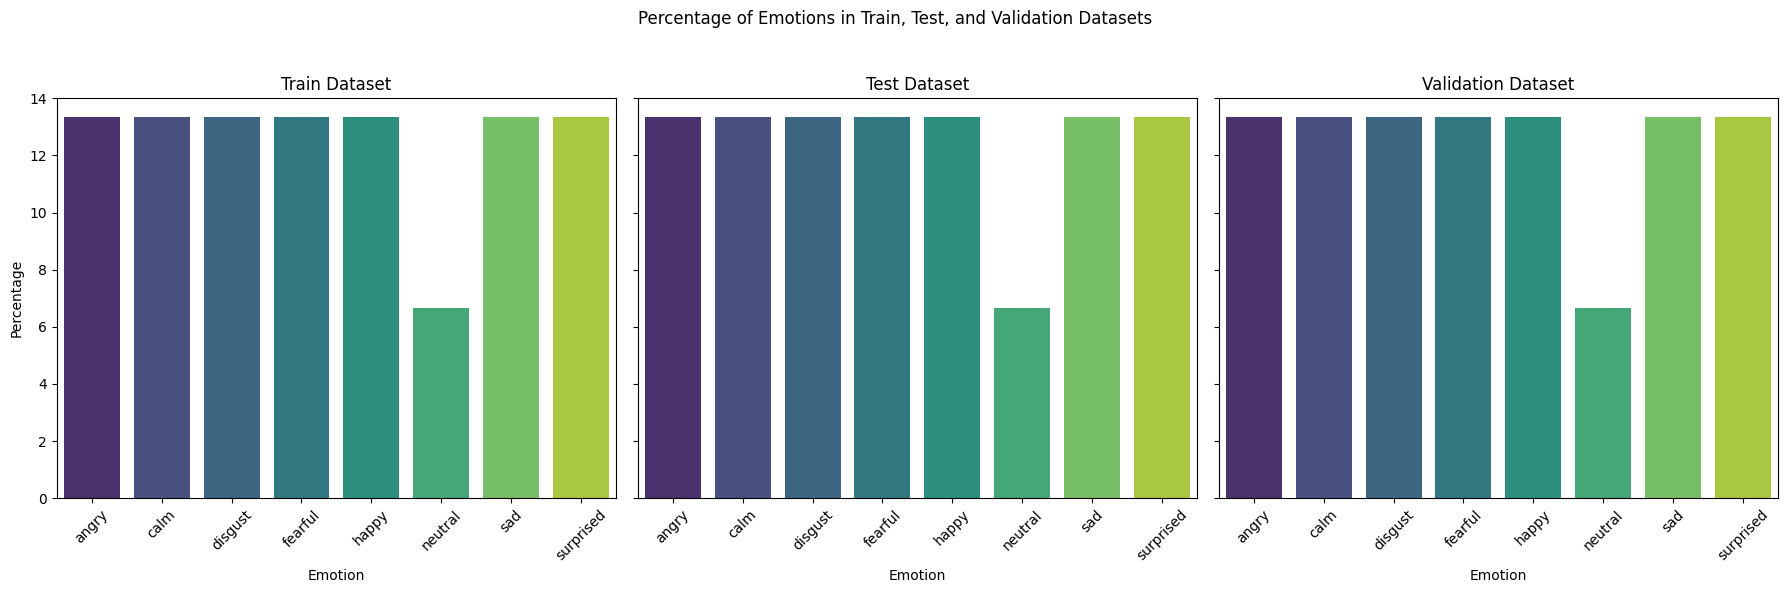

In [10]:
datasets = [train_dataset, test_dataset, val_dataset]
dataset_names = ['Train', 'Test', 'Validation']
emotion_counts = []
for dataset in datasets:
  emotion_counts_i = dataset['Emotion'].value_counts(normalize=True) * 100
  emotion_counts.append(emotion_counts_i.sort_index())

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, (counts, name) in enumerate(zip(emotion_counts, dataset_names)):
    sns.barplot(x=counts.index, y=counts.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f'{name} Dataset')
    axes[i].set_xlabel('Emotion')
    axes[i].set_ylabel('Percentage' if i == 0 else '')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Percentage of Emotions in Train, Test, and Validation Datasets')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# plt.figure(figsize=(5, 3))
# sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
# plt.title('Percentage of Emotions in the Train Dataset')
# plt.xlabel('Emotion')
# plt.ylabel('Percentage')
# plt.xticks(rotation=45)
# plt.show()

In [11]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title('Waveplot')
#     plt.show()

def create_mfcc(data, sr):
    plt.figure(figsize=(12, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
#     plt.show()

def create_melspectrogram(data, sr):
    plt.figure(figsize=(12, 3))
    melspec = librosa.feature.melspectrogram(y=data, n_mels = 60)
    logspec = librosa.amplitude_to_db(melspec)
    librosa.display.specshow(logspec, sr=sr, x_axis='time', y_axis='hz')
    plt.title('Mel Spectrogram')
    plt.colorbar()
#     plt.show()

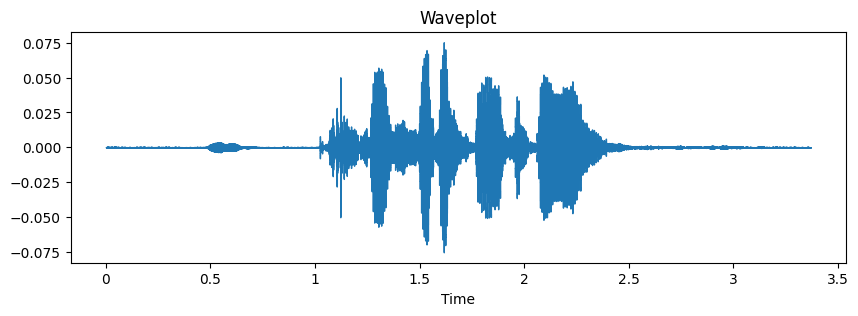

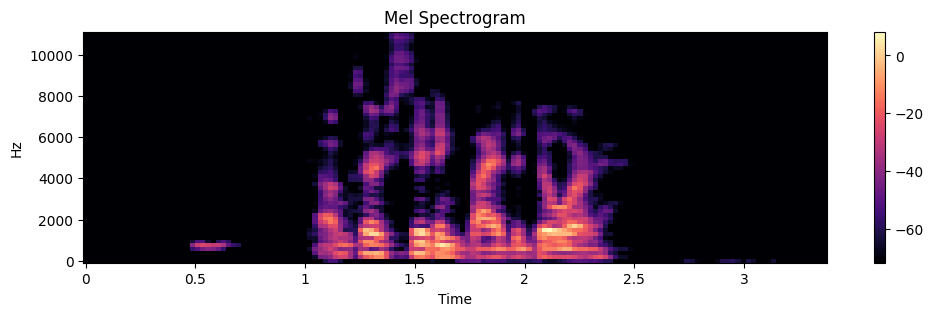

In [12]:
idx = 0
for root, dirs, files in os.walk(data_dir):
  for file in files:
    if file.endswith('.wav'):
      file_path = os.path.join(root, file)
      data, sampling_rate = librosa.load(file_path)
      create_waveplot(data, sampling_rate)
      # create_mfcc(data, sampling_rate)
      create_melspectrogram(data, sampling_rate)
      ipd.Audio(file_path)
      idx += 1
      # plt.show()
    if idx == 1:
      break
  if idx == 1:
      break

In [13]:
datasets = [train_dataset, test_dataset, val_dataset]
for idx in range(len(datasets)):
  datasets[idx] = datasets[idx].drop(['Modality', 'Vocal_channel', 'Emotional_intensity', 'Statement', 'Repetition', 'Gender', 'Actor'], axis=1)
train_dataset, test_dataset, val_dataset = datasets

In [14]:
train_dataset.head()

,audio_file,Emotion
0,./train_dataset/Actor_15/03-01-04-01-02-02-15.wav,sad
1,./train_dataset/Actor_15/03-01-03-01-01-02-15.wav,happy
2,./train_dataset/Actor_15/03-01-06-02-01-02-15.wav,fearful
3,./train_dataset/Actor_15/03-01-07-01-01-02-15.wav,disgust
4,./train_dataset/Actor_15/03-01-04-02-01-01-15.wav,sad


In [16]:
!pip install --upgrade resampy

In [18]:
import librosa
import resampy
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
def padding_and_offset(path, sr=16000, input_length=48000):
  # try:
  #     data, _ = librosa.load(path, sr=sr, res_type='kaiser_fast')
  # except Exception as e:
  #     print(f"Error loading {path}: {e}")
  #     return None
  data, _ = librosa.load(path, sr=sr, res_type='kaiser_fast')
  if len(data) > input_length:
    max_offset = len(data) - input_length
    offset = np.random.randint(max_offset)
    data = data[offset:(input_length+offset)]
  else:
    if input_length > len(data):
      max_offset = input_length - len(data)
      offset = np.random.randint(max_offset)
    else:
      offset = 0
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
  return data

def speed_pitch(data):
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.2  / length_change
  tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
  minlen = min(data.shape[0], tmp.shape[0])
  data *= 0
  data[0:minlen] = tmp[0:minlen]
  return data

def noise(data):
  noise_amp = 0.05*np.random.uniform()*np.amax(data)
  data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
  return data

In [24]:
from tqdm import tqdm

keys = ['Train', 'Test', 'Validation']
data_x, data_y = {}, {}
# aug_x, aug_y = {}, {}
aug_x, aug_y = [], []

for idx, dataset in enumerate(datasets):
  x_data, y_data = [], []
  x_aug, y_aug = [], []
  for r in tqdm(dataset.values):
    x = padding_and_offset(r[0])
    x_data.append(x)
    y_data.append(r[1])

    x_aug.append(speed_pitch(x))
    x_aug.append(noise(x))

    y_aug.extend([r[1], r[1]])

  x_data, y_data = np.array(x_data), np.array(y_data)
  x_aug, y_aug = np.array(x_aug), np.array(y_aug)
  data_x[keys[idx]], data_y[keys[idx]] = x_data, y_data
  # aug_x[keys[idx]], aug_y[keys[idx]] = x_aug, y_aug
  aug_x.append(x_aug)
  aug_y.append(y_aug)


100%|██████████| 240/240 [00:11<00:00, 21.18it/s]


In [30]:
def encode(e_data, df=train_dataset):
  e_encoder = LabelEncoder()
  e_encoder = e_encoder.fit(list(df['Emotion'].unique()))
  e_encoded = to_categorical(e_encoder.transform(e_data))
  return e_encoded

In [26]:
x_train, x_test, x_val, y_train, y_test, y_val = data_x['Train'], data_x['Test'], data_x['Validation'], data_y['Train'], data_y['Test'], data_y['Validation']

In [31]:
e_y = []
for e in y_train:
    e_y.append(e)
e_y_train = encode(e_y)

e_y = []
for e in y_test:
    e_y.append(e)
e_y_test = encode(e_y)

e_y = []
for e in y_val:
    e_y.append(e)
e_y_val = encode(e_y)

e_y_train_aug = []
for e in y_aug:
    e_y_train_aug.append(e)
e_y_train_aug = encode(e_y_train_aug)

In [32]:
x_train_aug = np.concatenate((x_train, x_aug), axis=0)
e_y_train_aug = np.concatenate((e_y_train, e_y_train_aug), axis=0)

np.random.seed(42)
np.random.shuffle(x_train_aug)
np.random.seed(42)
np.random.shuffle(e_y_train_aug)

In [33]:
def get_melspec(data):
  melspec = librosa.feature.melspectrogram(y=data, n_mels=60)
  logspec = librosa.amplitude_to_db(melspec)
  logspec = np.expand_dims(logspec, axis=-1)
  return logspec

In [36]:
x_train_melspec = []
x_test_melspec = []
x_val_melspec = []
x_train_aug_melspec = []

for i in x_train:
  melspec = get_melspec(i)
  x_train_melspec.append(melspec)

for i in x_test:
  melspec = get_melspec(i)
  x_test_melspec.append(melspec)

for i in x_val:
  melspec = get_melspec(i)
  x_val_melspec.append(melspec)

for i in x_train_aug:
  melspec = get_melspec(i)
  x_train_aug_melspec.append(melspec)

x_train_melspec, x_test_melspec, x_val_melspec, x_train_aug_melspec = np.array(x_train_melspec), np.array(x_test_melspec), np.array(x_val_melspec), np.array(x_train_aug_melspec)

In [37]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, Dropout, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
def get_2d_melspec_model(shape, n_emotions=8, n_sex=2):
    inputs = Input(shape=shape)
    x = Conv2D(32, (4,10), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    emotion_output = Dense(n_emotions, activation='softmax', name='emotion_output')(x)
    sex_output = Dense(n_sex, activation='sigmoid', name='sex_output')(x)

    model = Model(inputs, [emotion_output, sex_output])
    return model

In [43]:
def get_2d_melspec_model(shape, n_emotions=8):
    inputs = Input(shape=shape)
    x = Conv2D(32, (4,10), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    emotion_output = Dense(n_emotions, activation='softmax', name='emotion_output')(x)

    model = Model(inputs, emotion_output)
    return model

In [39]:
def get_callbacks(name_model):
    callbacks = [
        EarlyStopping(monitor="val_loss", mode="min", patience=20),
        ModelCheckpoint(name_model, monitor='val_loss', verbose=1, save_best_only=True)
    ]
    return callbacks

In [56]:
model_melspec = get_2d_melspec_model((60, 94, 1)) # Make sure this model has only one output layer for emotion classification
model_melspec.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
history_melspec = model_melspec.fit(x_train_melspec, e_y_train, validation_data=(x_val_melspec, e_y_val), callbacks=get_callbacks('best_melspec.h5'), epochs=100, batch_size=32)
# history_melspec = model_melspec.fit(x_test_melspec, e_y_test, validation_data=(x_val_melspec, e_y_val), callbacks=get_callbacks('best_melspec.h5'), epochs=10, batch_size=32)

Epoch 1/100
38/44 [========================>.....] - ETA: 0s - loss: 1.9065 - accuracy: 0.2401
Epoch 1: val_loss improved from inf to 4.84160, saving model to best_melspec.h5
44/44 [==============================] - 4s 16ms/step - loss: 1.9033 - accuracy: 0.2406 - val_loss: 4.8416 - val_accuracy: 0.2000
Epoch 2/100
43/44 [============================>.] - ETA: 0s - loss: 1.7913 - accuracy: 0.2871
Epoch 2: val_loss improved from 4.84160 to 3.30229, saving model to best_melspec.h5
44/44 [==============================] - 0s 10ms/step - loss: 1.7916 - accuracy: 0.2862 - val_loss: 3.3023 - val_accuracy: 0.1333
Epoch 3/100
43/44 [============================>.] - ETA: 0s - loss: 1.7239 - accuracy: 0.3408
Epoch 3: val_loss improved from 3.30229 to 1.66274, saving model to best_melspec.h5
44/44 [==============================] - 0s 10ms/step - loss: 1.7245 - accuracy: 0.3406 - val_loss: 1.6627 - val_accuracy: 0.3333
Epoch 4/100
43/44 [============================>.] - ETA: 0s - loss: 1.6750 -

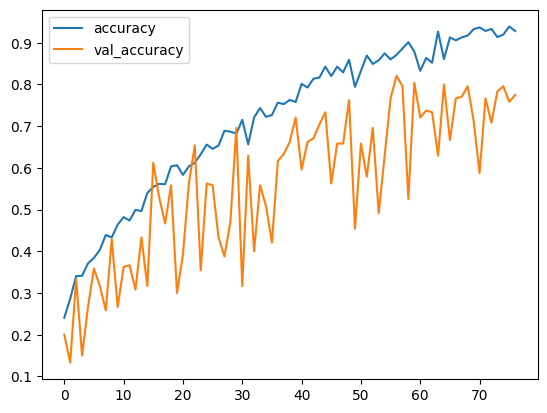

In [57]:
plt.plot(history_melspec.history['accuracy'])
plt.plot(history_melspec.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


In [58]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_melspec.evaluate(x_test_melspec, e_y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 [==============================] - 0s 4ms/step - loss: 0.7666 - accuracy: 0.7167
Test Loss: 0.7665989398956299
Test Accuracy: 0.7166666388511658


In [59]:
model_melspec_aug = get_2d_melspec_model((60, 94, 1)) # Make sure this model has only one output layer for emotion classification
model_melspec_aug.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
history_melspec_aug = model_melspec_aug.fit(x_train_aug_melspec, e_y_train_aug, validation_data=(x_val_melspec, e_y_val), callbacks=get_callbacks('best_melspec.h5'), epochs=100, batch_size=32)
# history_melspec = model_melspec_aug.fit(x_test_melspec, e_y_test, validation_data=(x_val_melspec, e_y_val), callbacks=get_callbacks('best_melspec.h5'), epochs=10, batch_size=32)


Epoch 1/100
56/59 [===========================>..] - ETA: 0s - loss: 1.8733 - accuracy: 0.2573
Epoch 1: val_loss improved from inf to 3.41232, saving model to best_melspec.h5
59/59 [==============================] - 4s 14ms/step - loss: 1.8720 - accuracy: 0.2570 - val_loss: 3.4123 - val_accuracy: 0.2417
Epoch 2/100
57/59 [===========================>..] - ETA: 0s - loss: 1.7285 - accuracy: 0.3224
Epoch 2: val_loss did not improve from 3.41232
59/59 [==============================] - 1s 9ms/step - loss: 1.7318 - accuracy: 0.3226 - val_loss: 3.9271 - val_accuracy: 0.2417
Epoch 3/100
55/59 [==========================>...] - ETA: 0s - loss: 1.6469 - accuracy: 0.3506
Epoch 3: val_loss improved from 3.41232 to 1.54172, saving model to best_melspec.h5
59/59 [==============================] - 1s 10ms/step - loss: 1.6502 - accuracy: 0.3473 - val_loss: 1.5417 - val_accuracy: 0.3833
Epoch 4/100
57/59 [===========================>..] - ETA: 0s - loss: 1.6022 - accuracy: 0.3723
Epoch 4: val_loss di

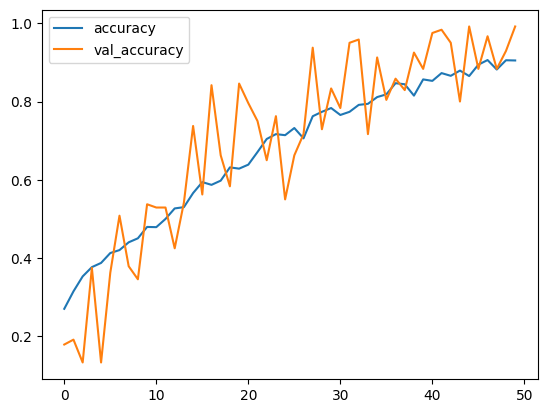

In [53]:
plt.plot(history_melspec_aug.history['accuracy'])
plt.plot(history_melspec_aug.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


In [55]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_melspec_aug.evaluate(x_test_melspec, e_y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.7556
Test Loss: 0.6901438236236572
Test Accuracy: 0.7555555701255798


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

e_y_test = np.argmax(e_y_test, axis=1)

def get_prediction(model, x):
    y_pred_e = model.predict(x)
    y_pred_e = np.argmax(y_pred_e, axis=1)
    return y_pred_e

def display_results(y_pred_e, y_true_e, df=test_dataset):
    e_conf_matrix = confusion_matrix(y_true_e, y_pred_e)
    e_df = pd.DataFrame(e_conf_matrix, index=list(df['Emotion'].unique()), columns=list(df['Emotion'].unique()))
    print(classification_report(y_true_e, y_pred_e, target_names=list(df['Emotion'].unique())))
    sns.heatmap(e_df, annot=True, fmt='g')
    plt.show()

In [62]:
y_pred_e = get_prediction(model_melspec, x_test_melspec)

6/6 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

        calm       0.78      0.75      0.77        24
     disgust       0.57      0.96      0.72        24
     neutral       0.60      0.75      0.67        24
   surprised       0.95      0.75      0.84        24
     fearful       0.74      0.83      0.78        24
         sad       0.60      0.50      0.55        12
       angry       0.67      0.42      0.51        24
       happy       1.00      0.67      0.80        24

    accuracy                           0.72       180
   macro avg       0.74      0.70      0.70       180
weighted avg       0.75      0.72      0.71       180



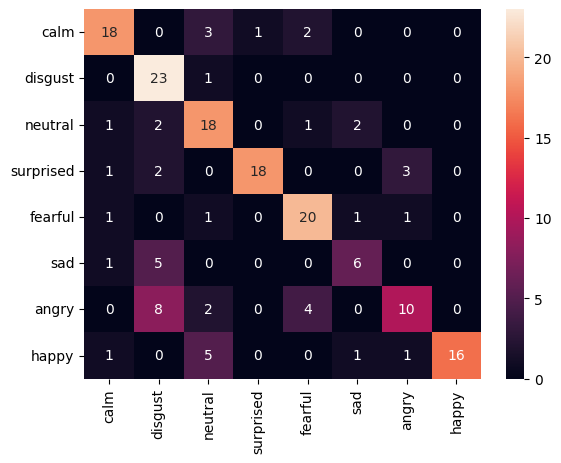

In [68]:
display_results(y_pred_e, e_y_test)

In [69]:
y_pred_e = get_prediction(model_melspec_aug, x_test_melspec)

6/6 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

        calm       0.95      0.75      0.84        24
     disgust       0.83      0.83      0.83        24
     neutral       0.89      0.67      0.76        24
   surprised       1.00      0.88      0.93        24
     fearful       0.71      0.83      0.77        24
         sad       0.61      0.92      0.73        12
       angry       0.58      0.62      0.60        24
       happy       0.92      1.00      0.96        24

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.80       180
weighted avg       0.83      0.81      0.81       180



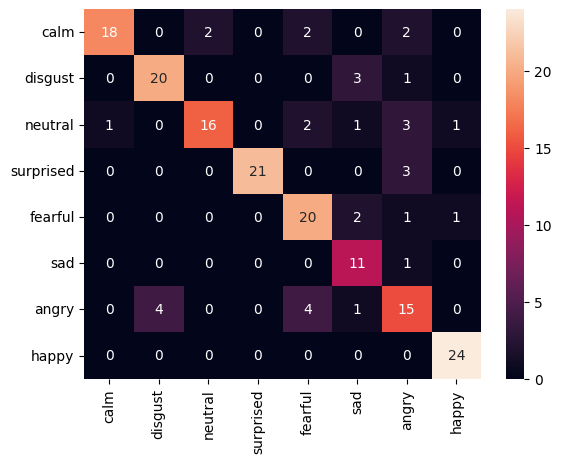

In [70]:
display_results(y_pred_e, e_y_test)